In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker
import numpy as np
import pickle
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.diagnostic import acorr_ljungbox as lb_test
import pmdarima as pm
from sklearn.linear_model import LinearRegression


In [2]:
xls = pd.ExcelFile('5_Years_USD-RW.xlsx')
df_forex_five_year = pd.read_excel(xls, '5_Years_USD-RW')
df_forex_ten_year = pd.read_excel(xls, '10_Years_USD-RW')

In [3]:
#5 year
df_forex_five_year = df_forex_five_year.drop(['Open', 'High', "Low", "Adj Close", "Volume"], axis=1)
df_forex_five_year['Date'] = pd.to_datetime(df_forex_five_year['Date'], format= '%d/%m/%Y')
df_forex_five_year = df_forex_five_year.set_index('Date')

#10 year
df_forex_ten_year = df_forex_ten_year.drop(['Open', 'High', "Low", "Adj Close", "Volume"], axis=1)
df_forex_ten_year['Date'] = pd.to_datetime(df_forex_ten_year['Date'], format= '%d/%m/%Y')
df_forex_ten_year = df_forex_ten_year.set_index('Date')

In [4]:
df_forex_five_year

,Close
Date,
2019-10-14,1182.489990
2019-10-15,1182.300049
2019-10-16,1183.930054
2019-10-17,1184.829956
2019-10-18,1177.270020
...,...
2023-10-10,1346.890015
2023-10-11,1341.890015
2023-10-12,1338.260010


In [5]:
df_forex_ten_year

,Close
Date,
2013-10-14,1069.199951
2013-10-15,1070.199951
2013-10-16,1063.500000
2013-10-17,1066.000000
2013-10-18,1061.699951
...,...
2023-10-09,1343.359985
2023-10-10,1346.890015
2023-10-11,1341.890015


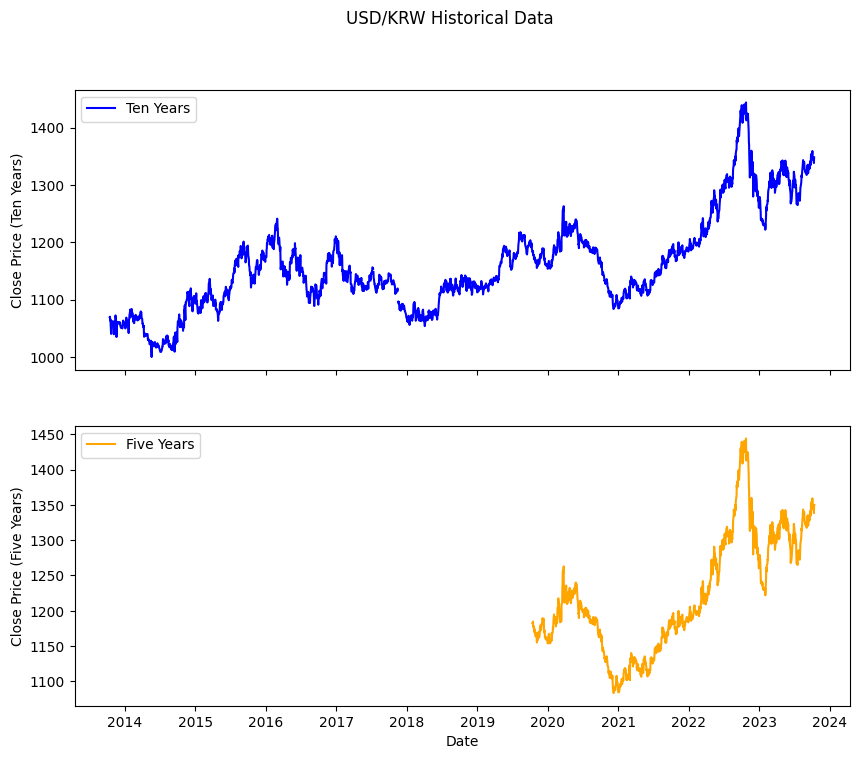

In [6]:
fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Plot for ten years
axs[0].plot(df_forex_ten_year.index, df_forex_ten_year['Close'], label='Ten Years', color='blue')
axs[0].set_ylabel('Close Price (Ten Years)')
axs[0].legend()

# Plot for five years
axs[1].plot(df_forex_five_year.index, df_forex_five_year['Close'], label='Five Years', color='orange')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Close Price (Five Years)')
axs[1].legend()

# Adding title
plt.suptitle('USD/KRW Historical Data')

# Display the plot
plt.show()

In [7]:
start_date = '2019-10-14'
end_date = '2022-1-1'
df_three_years = df_forex_five_year.loc[(df_forex_five_year.index < start_date) | (df_forex_five_year.index > end_date)].copy()

In [8]:
df_three_years

,Close
Date,
2022-01-03,1187.780029
2022-01-04,1194.680054
2022-01-05,1196.500000
2022-01-06,1199.250000
2022-01-07,1205.780029
...,...
2023-10-10,1346.890015
2023-10-11,1341.890015
2023-10-12,1338.260010


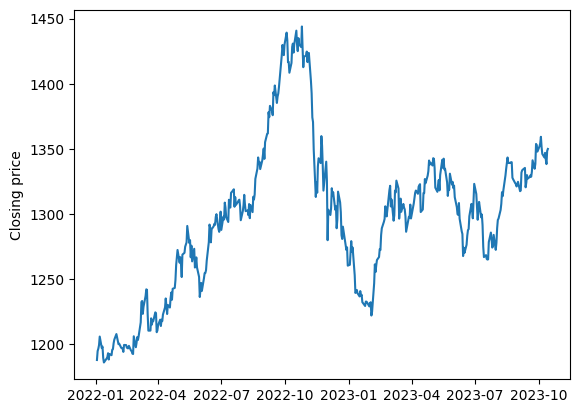

In [9]:
plt.plot(df_three_years['Close'])
plt.ylabel('Closing price')
plt.show()

Stationary - Integrated (parameter d)
d = 1

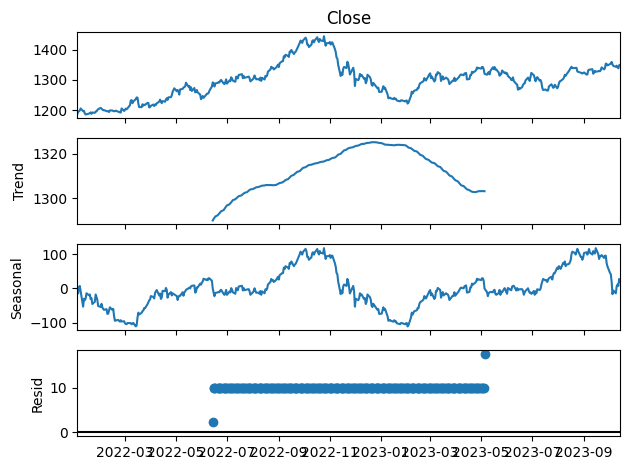

In [10]:
decomposition = seasonal_decompose(
    df_three_years['Close'], period=int(len(df_three_years)/2))
decomposition.plot()
plt.show()
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid


In [11]:
X = df_three_years.Close
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.317378
p-value: 0.166425
Critical Values:
	1%: -3.445
	5%: -2.868
	10%: -2.570


<Axes: xlabel='Date'>

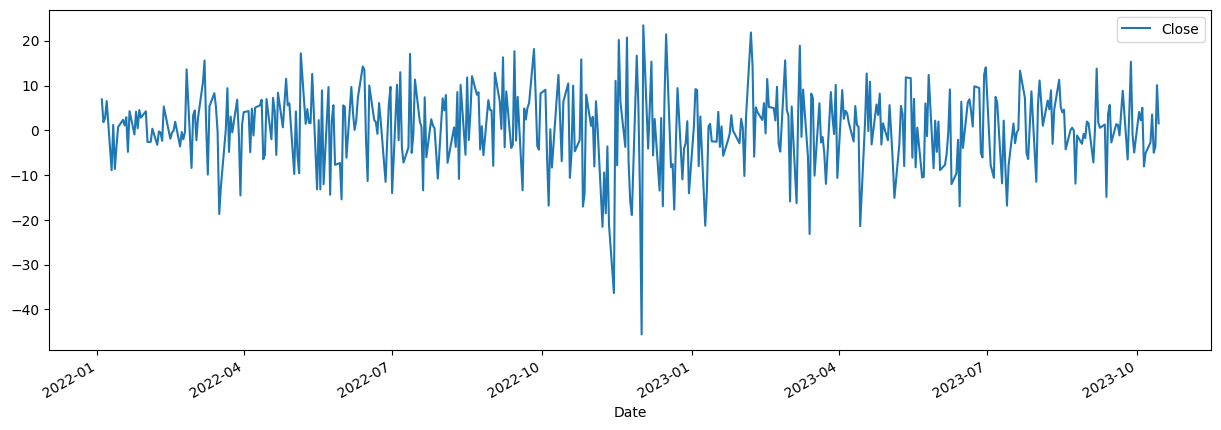

In [12]:
data_diff = df_three_years.diff().dropna()
data_diff.plot(figsize=(15,5))

In [13]:
dataX = data_diff.Close
fuller = adfuller(dataX)
print('ADF Statistic: %f' % fuller[0])
print('p-value: %f' % fuller[1])
print('Critical Values:')
for key, value in fuller[4].items():
	print('\t%s: %.3f' % (key, value))


ADF Statistic: -4.879038
p-value: 0.000038
Critical Values:
	1%: -3.445
	5%: -2.868
	10%: -2.570


    lb_stat  lb_pvalue
1  0.643331   0.422507
0.16642454034248993


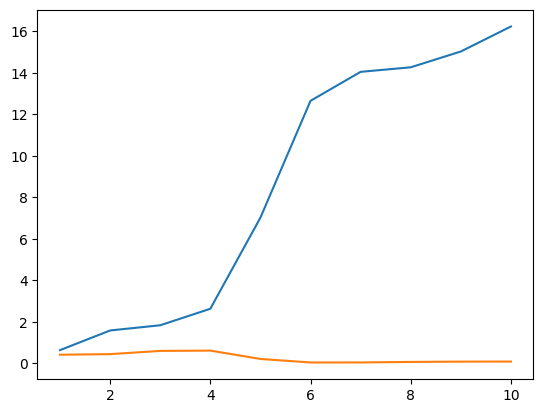

In [14]:
white_noise_result = lb_test(data_diff.Close, lags=1)
temp = result[1]
print(white_noise_result)
print(temp)
plt.plot(lb_test(data_diff.Close))
plt.show()


In [15]:
def draw_acf(data):
    plot_acf(data)
    plt.title("ACF")
    plt.show()
    
def draw_pacf(data):
    plot_pacf(data)
    plt.title("PACF")
    plt.show()

def draw_acf_pacf(data):
    f = plt.figure(facecolor = "white")
    
    ax1 = f.add_subplot(211)
    x_major_locator = matplotlib.ticker.MultipleLocator(1)
    plot_acf(data, ax=ax1)
    
    ax2 = f.add_subplot(212)
    plot_pacf(data, ax=ax2)
    plt.subplots_adjust(hspace = 0.5)
    
    ax1.xaxis.set_major_locator(x_major_locator)
    ax2.xaxis.set_major_locator(x_major_locator)
    plt.show

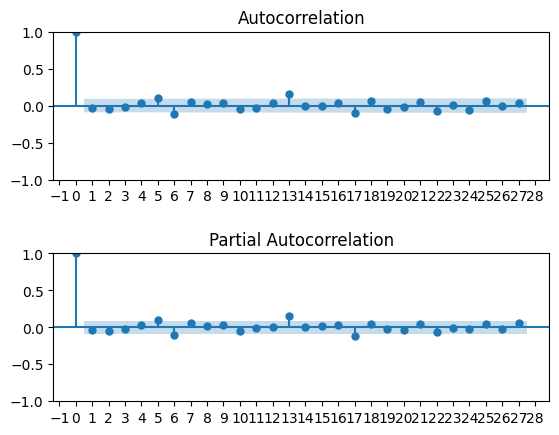

In [16]:
draw_acf_pacf(data_diff)


In [17]:
train_set, test_set= np.split(df_three_years, [int(.67 *len(df_three_years))])
built_arimamodel = pm.auto_arima(
    train_set,
    start_p = 0,
    start_q = 0,
    test = 'adf',
    max_p = 5,
    max_q = 5,
    m = 12,
    d = None,
    seasonal = True, start_P = 0, D = 1, trace = True,
    error_action = 'ignore', suppress_warnings = True,
    stepwise = False
)
print(built_arimamodel.summary())


 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2368.607, Time=0.06 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=0.38 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Time=1.60 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=2313.546, Time=0.11 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.50 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=inf, Time=1.97 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=2277.117, Time=0.26 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=1.75 sec
 ARIMA(0,1,0)(2,1,2)[12]             : AIC=inf, Time=2.76 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=2362.750, Time=0.06 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.59 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=inf, Time=2.03 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=2310.712, Time=0.14 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.88 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=3.17 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=22

https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.AutoARIMA.html

Best model:  ARIMA(0, 1, 0)x(2, 1, 0, 12) intercept

Typically when implementing ARIMA/SARIMA models the parameters p, d, and q for ARIMA modeling and p, d, q, P, D, Q, and m for SARIMA modeling need to be known.
p is the trend autoregressive order
d is the trend differencing order
q is the trend moving average order
P is the seasonal autoregressive order
D is the seasonal differencing order
Q is the seasonal moving average order
m is the number of steps in a seasonal period

In [18]:
print(built_arimamodel.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  312
Model:             SARIMAX(0, 1, 0)x(2, 1, 0, 12)   Log Likelihood               -1135.558
Date:                            Sat, 11 Nov 2023   AIC                           2277.117
Time:                                    01:13:44   BIC                           2288.218
Sample:                                01-03-2022   HQIC                          2281.560
                                     - 03-14-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.5747      0.054    -10.684      0.000      -0.680      -0.469
ar.S.L24      -0.3477      0.057   

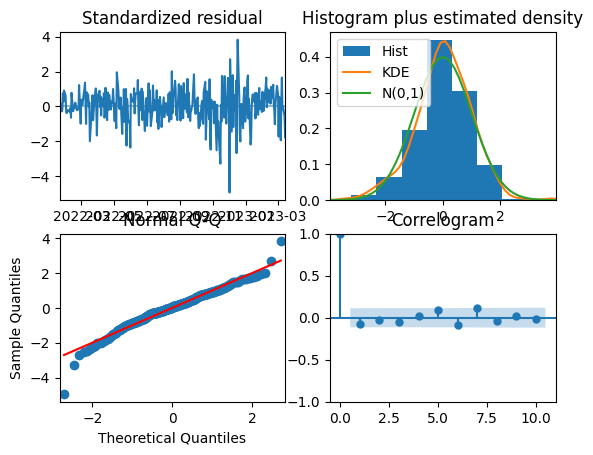

In [19]:
built_arimamodel.plot_diagnostics()
plt.show()

In [20]:
pred_list = []
for index, row in test_set.iterrows():
    pred_list += [built_arimamodel.predict(n_periods=1)]
    built_arimamodel.update(row)
    predict_f1 = built_arimamodel.predict(n_periods=1)
    print("Future prediction:", predict_f1[0])


Future prediction: 1308.659211794795
Future prediction: 1313.624736873401
Future prediction: 1295.9959727587775
Future prediction: 1308.7104681114408
Future prediction: 1301.6703179475207
Future prediction: 1306.6477094346394
Future prediction: 1303.6948870095039
Future prediction: 1287.267923780301
Future prediction: 1308.6692118947929
Future prediction: 1299.8100525490788
Future prediction: 1284.276902570041
Future prediction: 1315.9921637720297
Future prediction: 1301.9500793959792
Future prediction: 1303.0192846464556
Future prediction: 1308.9121904552485
Future prediction: 1312.3169351578276
Future prediction: 1315.948289099823
Future prediction: 1318.7496429890214
Future prediction: 1316.8677744580468
Future prediction: 1324.7437635460594
Future prediction: 1328.9725379703143
Future prediction: 1319.9914749993427
Future prediction: 1298.2487870929465
Future prediction: 1306.7474310776258
Future prediction: 1323.0258302761597
Future prediction: 1315.728179877466
Future prediction:

In [21]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))
    me = np.mean(forecast - actual)
    mae = np.mean(np.abs(forecast - actual))
    mpe = np.mean((forecast - actual)/(actual))

    rmse_1 = np.sqrt(sum((forecast - actual) ** 2)/ actual.size)
    corr = np.corrcoef(forecast, actual)[0,1]
    mins = np.amin(np.hstack([forecast[:, None], actual[:, None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:, None], actual[:, None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)
    return({
        "mape": mape,
        "me": me,
        "mae": mae,
        "mpe": mpe,
        "rmse": rmse_1,
        "corr": corr,
        "minmax": minmax,
    })


model evaluation result
 {'mape': 0.005249061666601083, 'me': 0.11614547825987397, 'mae': 6.89451833582652, 'mpe': 9.843539357400436e-05, 'rmse': array([8.69599365]), 'corr': nan, 'minmax': 0.005227068665762946}


c:\Users\LO TSZ FOR JAMES\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
c:\Users\LO TSZ FOR JAMES\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
c:\Users\LO TSZ FOR JAMES\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


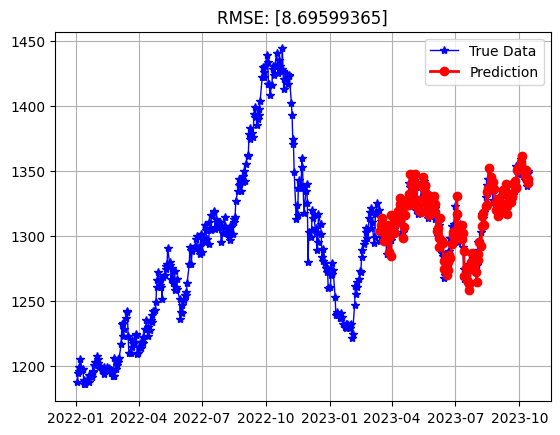

In [22]:
test_predict = test_set.copy()
for x in range(len(test_predict)):
    test_predict.iloc[x] = pred_list[x]

eval_result = forecast_accuracy(test_predict.values, test_set.values)
print("model evaluation result\n", eval_result)

plt.plot(df_three_years, 'b-', lw=1, label='True Data', marker ='*')
plt.plot(test_predict, 'r-', lw=2, label='Prediction', marker='o')
plt.title('RMSE: {}'.format(eval_result['rmse']))
plt.legend(loc = 'best')
plt.grid()
plt.show()


In [23]:
model_arima_file = "arima_model.pkl"

with open(model_arima_file, 'wb') as file:
    pickle.dump(built_arimamodel, file)


Below - Draft (please ignore):

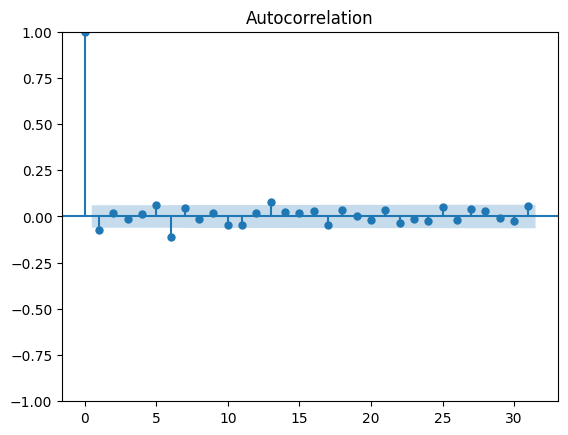

In [11]:
plot_acf(np.array(data_diff))
plt.show()


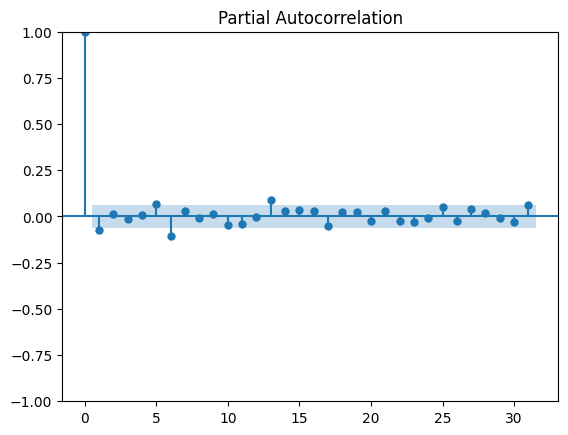

In [12]:
plot_pacf(np.array(data_diff))
plt.show()


In [16]:
train_set, test_set= np.split(df_three_years, [int(.67 *len(df_three_years))])
x_train, x_test = np.array(range(train_set.shape[0])), np.array(
    range(train_set.shape[0], df_three_years.shape[0]))
train_set.shape, x_train.shape, test_set.shape, x_test.shape


((700, 1), (700,), (346, 1), (346,))

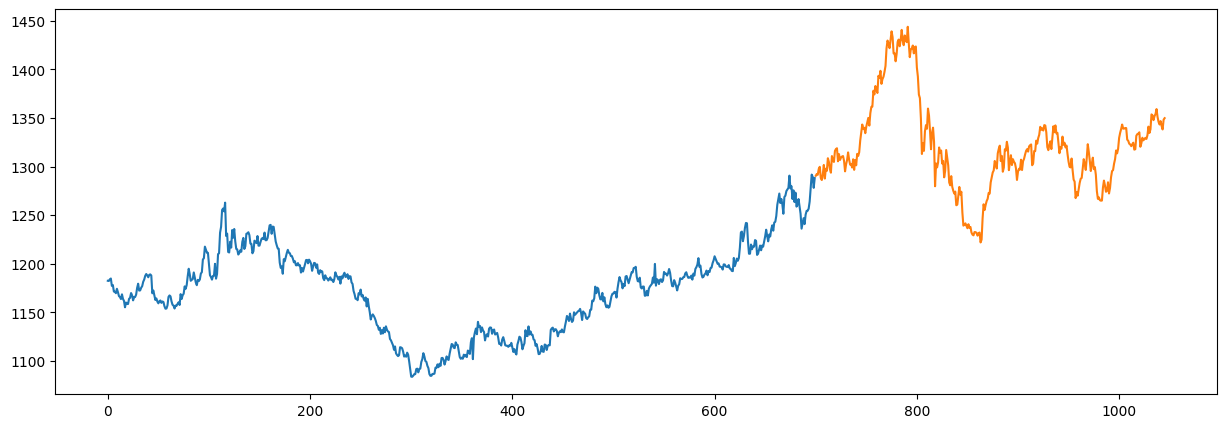

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(x_train, train_set)
ax.plot(x_test, test_set)


In [21]:
from pmdarima.arima import ARIMA
from pmdarima.arima import ndiffs
from pmdarima.arima import nsdiffs


In [22]:
ndiffs(df_three_years)
nsdiffs(df_three_years, 365)

1

In [ ]:
model = ARIMA(order=(2, 1, 0))
results = model.fit(train_set)


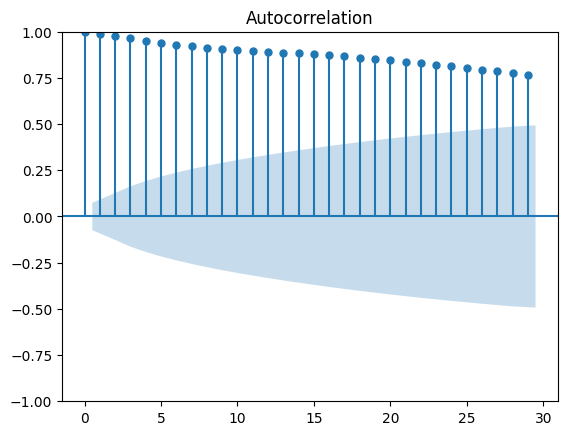

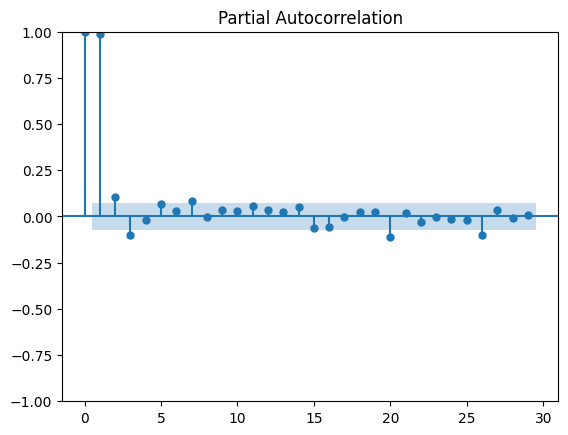

In [49]:
acf_original = plot_acf(train_set)
pacf_original = plot_pacf(train_set)


In [52]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(train_set)
print(f'p-value: {adf_test[1]}')


p-value: 0.9035175852884436


In [56]:
adf_test = adfuller(train_set.dropna())
print(f'p-value: {adf_test[1]}')

adf_test = adfuller(train_set.diff().dropna())
print(f'p-value: {adf_test[1]}')

adf_test = adfuller(train_set.diff().diff().dropna())
print(f'p-value: {adf_test[1]}')


p-value: 0.9035175852884436
p-value: 1.200055342008049e-21
p-value: 2.1030305565879675e-19


In [63]:
import statsmodels.api as sm

arima_model = sm.tsa.arima.ARIMA(train_set.Close, order=(1, 1, 2))
model = arima_model.fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  700
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -2219.749
Date:                Sat, 14 Oct 2023   AIC                           4447.499
Time:                        13:54:38   BIC                           4465.697
Sample:                    10-14-2019   HQIC                          4454.534
                         - 06-17-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2460      0.289     -0.850      0.395      -0.813       0.321
ma.L1          0.1328      0.286      0.464      0.642      -0.428       0.694
ma.L2          0.0888      0.047      1.881      0.0

c:\Users\LO TSZ FOR JAMES\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
c:\Users\LO TSZ FOR JAMES\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
c:\Users\LO TSZ FOR JAMES\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


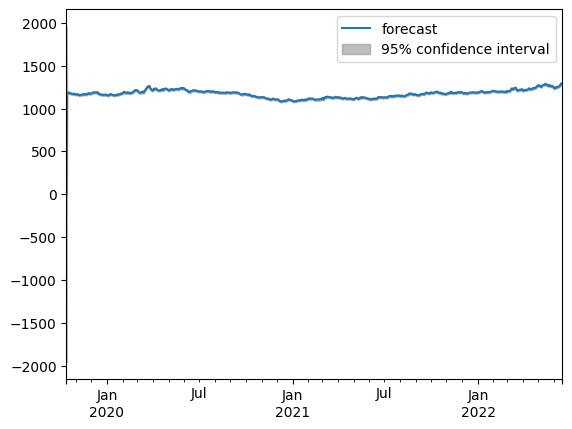

In [71]:
from statsmodels.graphics.tsaplots import plot_predict

plot_predict(model, dynamic=False)
plt.show()


In [ ]:
https://www.anyscale.com/blog/scaling-time-series-forecasting-on-ray-arima-and-prophet-on-ray
https://www.justintodata.com/arima-models-in-python-time-series-prediction/ 

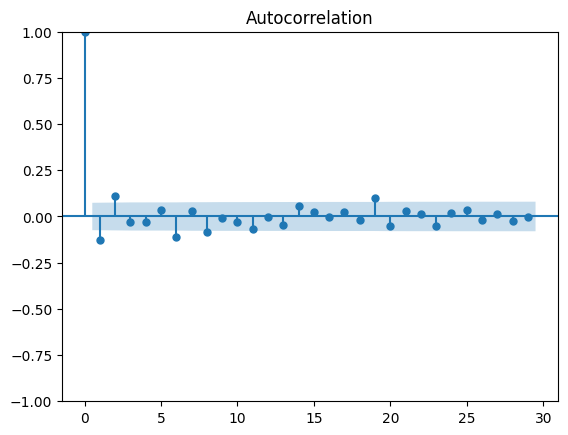

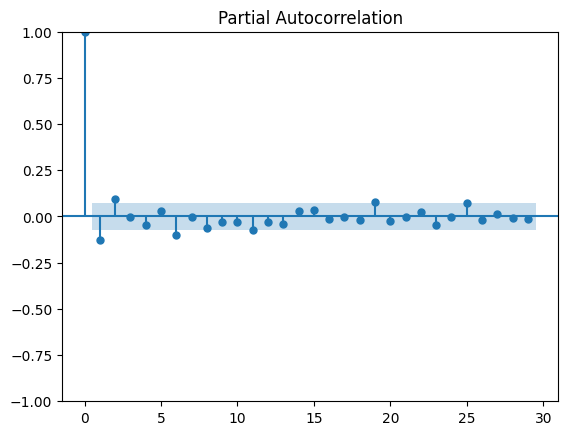

In [54]:
acf_diff = plot_acf(df_train_diff)
pacf_diff = plot_pacf(df_train_diff)


In [55]:
adf_test = adfuller(df_train_diff)
print(f'p-value: {adf_test[1]}')


p-value: 1.200055342008049e-21
